In [1]:
import json
from pathlib import Path

import fire
import wandb

from spd.configs import Config
from spd.experiments.tms.configs import TMSTaskConfig
from spd.experiments.tms.models import TMSModel, TMSTargetRunInfo
from spd.log import logger
from spd.run_spd import optimize
from spd.utils.data_utils import DatasetGeneratedDataLoader, SparseFeatureDataset
from spd.utils.distributed_utils import get_device
from spd.utils.general_utils import (
    load_config,
    save_pre_run_info,
    set_seed,
)
from spd.utils.run_utils import get_output_dir
from spd.utils.wandb_utils import init_wandb
from spd.experiments.resid_mlp.configs import ResidMLPTaskConfig
from spd.experiments.resid_mlp.models import (
    ResidMLP,
    ResidMLPTargetRunInfo,
    ResidMLPWithModules,
)

config = load_config("../experiments/resid_mlp/resid_mlp1_config.yaml", config_model=Config)
device = get_device()

assert config.pretrained_model_path, "pretrained_model_path must be set"
target_run_info = ResidMLPTargetRunInfo.from_path(config.pretrained_model_path)
target_model = ResidMLP.from_run_info(target_run_info)
target_model = target_model.to(device)
target_model.eval()


/workspace/spd-backchaining/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Downloaded checkpoint from /workspace/spd-backchaining/wandb/pziyck78/files/resid_mlp.pth


ResidMLP(
  (layers): ModuleList(
    (0): MLP(
      (mlp_in): Linear(in_features=1000, out_features=50, bias=False)
      (mlp_out): Linear(in_features=50, out_features=1000, bias=False)
    )
  )
)

In [2]:
import torch
def clone_resid_mlp_with_modules(model: ResidMLP):
    """Convert an existing ResidMLP with Parameter weights into one with nn.Linear modules."""
    new_model = ResidMLPWithModules(model.config)

    # Copy weights into Linear layers
    with torch.no_grad():
        new_model.W_E.weight.copy_(model.W_E.T)  # because einsum used (n_features, d_embed)
        new_model.W_U.weight.copy_(model.W_U.T)  # because einsum used (d_embed, n_features)

    # Copy over MLP layers
    for old_layer, new_layer in zip(model.layers, new_model.layers):
        new_layer.load_state_dict(old_layer.state_dict())

    return new_model

In [3]:
target_model2 = clone_resid_mlp_with_modules(target_model)

In [5]:
import torch
target_model.to(device)
target_model2.to(device)
rand_input = torch.randn(1, 100).to(device)
print(target_model2(rand_input))
print(target_model(rand_input))


tensor([[ 0.7380, -0.4199, -0.4555,  0.6548,  1.7472, -0.3681,  0.7213,  2.4019,
         -2.1391, -2.1132, -2.0530, -1.5344,  2.8540, -0.4720,  2.3941, -1.1149,
         -0.9408,  0.0777, -0.3078, -0.9512, -0.1013, -2.4041, -1.4461,  1.2082,
         -1.3846,  3.2249,  0.3118,  1.3948, -0.9966,  2.1072, -0.5064, -2.6654,
          1.9799,  0.1617,  1.3423, -0.3584, -0.7323,  0.8860, -0.6438,  0.6853,
          1.9704, -0.7558,  2.0925,  0.3650, -0.7836,  0.9585,  0.3227,  0.9258,
         -2.1166,  0.1471,  0.5450, -1.9290,  1.2031, -0.5399, -0.6416, -0.0762,
         -0.7503,  1.8603, -1.1005, -0.0585, -1.3070, -0.3402, -0.8111, -0.6773,
         -1.6958,  0.1332, -1.9222,  0.3932, -0.4003, -1.4902, -0.6510, -0.0445,
         -1.1826,  0.0602,  0.2962, -2.3167,  0.3182, -1.4248, -0.7470,  1.6775,
          0.7095, -0.6357, -0.5102,  0.4133,  0.6504,  1.1120, -0.0707, -0.6436,
         -1.0932,  1.0367, -0.2839,  1.0841,  0.3830,  0.2022,  1.9352, -1.0633,
         -0.9117, -0.8713, -

spd-sh0n7gl1 #1
spd-kre4rnff #2
spd-s8gdaz5i #1 including W_E, W_U  10000 iterations
spd-0x4qmyr6 #1 inclucing W_E, W_U, 30000 iterations

In [6]:
from spd.models.component_model import ComponentModel
import torch

state_dict = torch.load("/root/spd_cache/runs/spd-0x4qmyr6/model_30000.pth", map_location="cpu")

target_model2.requires_grad_(False)
component_model = ComponentModel(
    target_model=target_model2,
    target_module_patterns=config.target_module_patterns,
    C=config.C,
    gate_type=config.gate_type,
    gate_hidden_dims=config.gate_hidden_dims,
    pretrained_model_output_attr=config.pretrained_model_output_attr,
    identity_module_patterns=config.identity_module_patterns,
)

component_model.load_state_dict(state_dict)
component_model.eval()


W_E
W_U
layers
layers.0
layers.0.mlp_in
layers.0.mlp_out


ComponentModel(
  (patched_model): ResidMLPWithModules(
    (W_E): ComponentsOrModule(
      (original): Linear(in_features=100, out_features=1000, bias=False)
      (components): LinearComponents()
    )
    (W_U): ComponentsOrModule(
      (original): Linear(in_features=1000, out_features=100, bias=False)
      (components): LinearComponents()
    )
    (layers): ModuleList(
      (0): MLP(
        (mlp_in): ComponentsOrModule(
          (original): Linear(in_features=1000, out_features=50, bias=False)
          (components): LinearComponents()
        )
        (mlp_out): ComponentsOrModule(
          (original): Linear(in_features=50, out_features=1000, bias=False)
          (components): LinearComponents()
        )
      )
    )
  )
  (_gates): ModuleDict(
    (W_E): GateMLPs(
      (layers): Sequential(
        (0): ParallelLinear()
        (1): GELU(approximate='none')
        (2): ParallelLinear()
      )
    )
    (W_U): GateMLPs(
      (layers): Sequential(
        (0): Para

In [37]:
print(type(component_model._gates.W_E))

<class 'spd.models.components.GateMLPs'>


In [7]:
components = {
    "W_E": {
        "U": component_model.patched_model.W_E.components.U,
        "V": component_model.patched_model.W_E.components.V,
    },
    "W_in": {
        "U": component_model.patched_model.layers[0].mlp_in.components.U,
        "V": component_model.patched_model.layers[0].mlp_in.components.V,
    },
    "W_out": {
        "U": component_model.patched_model.layers[0].mlp_out.components.U,
        "V": component_model.patched_model.layers[0].mlp_out.components.V,
    },
    "W_U": {
        "U": component_model.patched_model.W_U.components.U,
        "V": component_model.patched_model.W_U.components.V,
    },
}

In [54]:
from spd.experiments.resid_mlp.resid_mlp_dataset import ResidMLPDataset
from spd.log import logger
from spd.run_spd import optimize
from spd.utils.data_utils import DatasetGeneratedDataLoader
from spd.data import loop_dataloader

synced_inputs = target_run_info.config.synced_inputs
dataset = ResidMLPDataset(
    n_features=target_model.config.n_features,
    feature_probability=config.task_config.feature_probability,
    device=device,
    calc_labels=True,  # Our labels will be the output of the target model
    label_type="act_plus_resid",
    act_fn_name="relu",
    label_fn_seed=None,
    label_coeffs=None,
    data_generation_type=config.task_config.data_generation_type,
    synced_inputs=synced_inputs,
)
train_loader = DatasetGeneratedDataLoader(
    dataset, batch_size=config.microbatch_size, shuffle=False
)
train_iterator = loop_dataloader(train_loader)

In [72]:
data = next(train_iterator)
print(data[0][0, :])
print(data[1][0, :])


tensor([0.0000, -0.0000, 0.0000, 0.0000, 0.7631, -0.0000, 0.0000, -0.0000, -0.0000,
        -0.0000, 0.0000, 0.0000, -0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -0.0000,
        -0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000,
        -0.0000, -0.0000, 0.0000, -0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000,
        0.0000, 0.0000, 0.0000, -0.0000, -0.0000, 0.0000, -0.0000, -0.0000, 0.0000,
        -0.0000, 0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, 0.0000, 0.0000, 0.0000, -0.0000, -0.0000, 0.0000,
        -0.0000, -0.0000, 0.0000, 0.0000, 0.0000, -0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, -0.0000, -0.0000, -0.0000, -0.0000, 0.0000,
        -0.0000, -0.0000, 0.0000, 0.0000, -0.0000, -0.0000, 0.0000, 0.0000, -0.0000,
        0.0000, -0.0000, -0.0000, 0.0000, -0.0000, 0.0000, 0.0000, -0.0000, -0.0000,
        0.0000], device='cuda:0')
tensor([0.0000, 0.0000, 0.0000, 0.000

In [23]:
print(component_model.patched_model.W_U.components.weight)
print(component_model.patched_model.W_U.original.weight)
# Print the mean squared error between the two
print(torch.nn.functional.mse_loss(component_model.patched_model.W_U.components.weight.to(device), component_model.patched_model.W_U.original.weight.to(device)))

tensor([[-0.0152, -0.0157, -0.1000,  ...,  0.0193,  0.0482,  0.1096],
        [-0.0047,  0.0329,  0.0135,  ..., -0.0373, -0.0408, -0.0080],
        [ 0.0469,  0.0212,  0.0081,  ..., -0.0018,  0.0140,  0.0035],
        ...,
        [ 0.0126, -0.0553,  0.0158,  ...,  0.0395,  0.0314,  0.0510],
        [ 0.0110, -0.0313,  0.0405,  ...,  0.0257, -0.0508, -0.0119],
        [-0.0068, -0.0051, -0.0339,  ..., -0.0398, -0.0621, -0.0313]],
       grad_fn=<ViewBackward0>)
Parameter containing:
tensor([[-0.0301, -0.0139, -0.0862,  ...,  0.0065,  0.0442,  0.0740],
        [-0.0120,  0.0391,  0.0340,  ..., -0.0344, -0.0315, -0.0144],
        [ 0.0419,  0.0295,  0.0045,  ..., -0.0019,  0.0138,  0.0160],
        ...,
        [ 0.0089, -0.0421,  0.0110,  ...,  0.0405,  0.0341,  0.0314],
        [ 0.0082, -0.0219,  0.0261,  ...,  0.0251, -0.0464, -0.0151],
        [-0.0042, -0.0160, -0.0538,  ..., -0.0281, -0.0564, -0.0248]],
       device='cuda:0')
tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackwa

In [32]:
target_direction = torch.zeros(100)
target_direction[5] = 1

read_norms = []
write_norms = []
# cos_sims = []

for c in range(100):
    write_direction = components["W_out"]["U"][c, :]
    read_direction = components["W_out"]["V"][:, c]
    # cos_sim = torch.nn.functional.cosine_similarity(write_direction, target_direction, dim=0)
    # cos_sims.append(cos_sim.item())
    read_norms.append(read_direction.norm().item())
    write_norms.append(write_direction.norm().item())
# print(cos_sims)

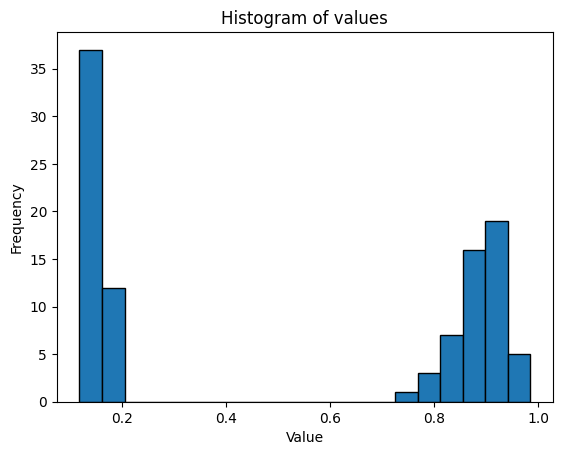

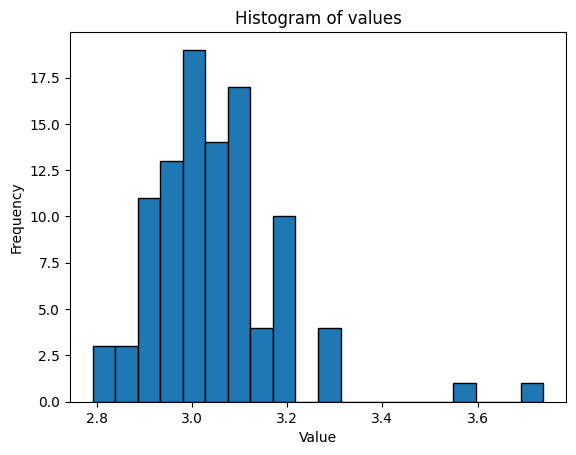

In [33]:
import matplotlib.pyplot as plt

# plt.hist(cos_sims, bins=20, edgecolor="black")  # bins controls granularity
# plt.xlabel("Value")
# plt.ylabel("Frequency")
# plt.title("Histogram of values")
# plt.show()

plt.hist(read_norms, bins=20, edgecolor="black")  # bins controls granularity
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of values")
plt.show()

plt.hist(write_norms, bins=20, edgecolor="black")  # bins controls granularity
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of values")
plt.show()

In [ ]:
target_neuron = 0
pre_unembedding_target_vector = W_U.T[target_neuron, :]
print(pre_unembedding_target_vector.shape)



torch.Size([1000])
tensor([-3.0146e-02, -1.3867e-02, -8.6196e-02,  4.7334e-03, -3.9406e-03,
        -1.8901e-02, -2.0307e-02, -1.0706e-02, -3.5033e-02, -1.1839e-02,
        -5.4481e-02,  7.3861e-02,  1.0162e-02, -6.0050e-03,  4.1948e-02,
         3.8535e-02, -4.1425e-03,  3.9674e-02,  4.6795e-02,  3.4574e-02,
        -1.6110e-02, -4.6438e-02, -2.3618e-02, -4.2294e-02,  2.2721e-03,
        -2.4147e-04,  6.1845e-02,  2.2423e-02, -2.5413e-03, -2.7297e-02,
         4.4035e-02, -9.3869e-03, -1.9448e-02, -1.0702e-02, -2.9623e-02,
        -2.6276e-02, -2.4148e-02, -1.6427e-03,  1.7719e-02,  4.9393e-02,
         4.6037e-04,  1.4776e-02,  5.3302e-02,  2.3226e-02, -5.8870e-03,
         3.3425e-02, -4.7670e-02, -2.4627e-02, -5.9871e-03,  1.2467e-02,
         1.2773e-02, -2.7057e-03,  2.9248e-02, -3.6263e-02,  3.6399e-03,
         1.5854e-02, -1.7929e-02, -1.0534e-02, -1.7830e-02,  2.9501e-02,
         9.2489e-03,  3.9460e-03,  1.5420e-02, -3.5285e-02, -1.0904e-03,
        -3.1737e-02,  3.1166e-02

# Simple arithmetic

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np


# -----------------------
# Data Generator
# -----------------------

def generate_data(n_samples: int, p_nonzero: float = 0.125, seed: int | None = None):
    """
    Generate sparse input data and 20 arithmetic targets.

    Args:
        n_samples: number of examples
        p_nonzero: probability each input feature is nonzero
        seed: random seed

    Returns:
        X: (n_samples, 16) torch.FloatTensor
        Y: (n_samples, 20) torch.FloatTensor
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    n_features = 16
    X = torch.zeros((n_samples, n_features))

    # Bernoulli mask for sparsity
    mask = torch.bernoulli(torch.full((n_samples, n_features), p_nonzero))
    values = torch.randn((n_samples, n_features))
    X = mask * values

    x = [X[:, i] for i in range(n_features)]

    # Build 20 tasks
    Y = torch.stack([
        x[0],                                # t0
        x[1],                                # t1
        x[0] + x[1],                         # t2
        x[0] * x[2],                         # t3
        x[3],                                # t4
        x[3] - x[4],                         # t5
        x[4] * x[5],                         # t6
        torch.max(x[3], x[5]),               # t7
        x[6] * x[7],                         # t8
        x[6] + 2 * x[7],                     # t9
        x[8] + x[9] + x[10],                 # t10
        (x[8] + x[9]) ** 2,                  # t11
        x[10] * (x[8] - x[9]),               # t12
        x[11],                               # t13
        x[12] * x[13],                       # t14
        x[11] + x[12] + x[13],               # t15
        x[14] * (x[11] + x[12]),             # t16
        (x[0] + x[1]) * x[5],                # t17
        (x[3] - x[4]) + x[7],                # t18
        x[9] * x[12],                        # t19
    ], dim=1)

    return X, Y


# -----------------------
# Model Definition
# -----------------------

class SparseMLP(nn.Module):
    def __init__(self, input_dim=16, hidden1=128, hidden2=64, output_dim=20):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden1, bias=False)
        self.fc2 = nn.Linear(hidden1, hidden2, bias=False)
        self.fc3 = nn.Linear(hidden2, output_dim, bias=False)

    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        out = self.fc3(h2)
        return out, (h1, h2)


# -----------------------
# Training Loop
# -----------------------

def train_model(
    model,
    train_loader,
    val_loader,
    n_epochs=20,
    lr=1e-3,
    device="cpu"
):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(1, n_epochs + 1):
        model.train()
        total_loss = 0.0
        for Xb, Yb in train_loader:
            Xb, Yb = Xb.to(device), Yb.to(device)
            optimizer.zero_grad()
            preds, _ = model(Xb)
            loss = loss_fn(preds, Yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * Xb.size(0)

        avg_loss = total_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            per_task_loss = torch.zeros(model.fc3.out_features, device=device)
            n_samples = 0
            hidden_activity = [0.0, 0.0]
            for Xb, Yb in val_loader:
                Xb, Yb = Xb.to(device), Yb.to(device)
                preds, (h1, h2) = model(Xb)
                loss = loss_fn(preds, Yb)
                val_loss += loss.item() * Xb.size(0)
                per_task_loss += ((preds - Yb) ** 2).mean(0) * Xb.size(0)
                n_samples += Xb.size(0)
                hidden_activity[0] += (h1 > 0).float().mean().item() * Xb.size(0)
                hidden_activity[1] += (h2 > 0).float().mean().item() * Xb.size(0)

            val_loss /= len(val_loader.dataset)
            per_task_loss /= n_samples
            hidden_activity = [ha / n_samples for ha in hidden_activity]

        if epoch % 50 == 0:
            print(f"Epoch {epoch:02d}: train_loss={avg_loss:.4f} val_loss={val_loss:.4f}")
            print(f"  Per-task MSE: {[f'{x:.4f}' for x in per_task_loss.tolist()]}")
            print(f"  Hidden layer activity (fraction active): h1={hidden_activity[0]:.3f}, h2={hidden_activity[1]:.3f}")


# -----------------------
# Usage Example
# -----------------------


# Generate data
X_train, Y_train = generate_data(10000, p_nonzero=0.125, seed=42)
X_val, Y_val = generate_data(2000, p_nonzero=0.125, seed=123)

train_ds = TensorDataset(X_train, Y_train)
val_ds = TensorDataset(X_val, Y_val)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256)

# Build model
model = SparseMLP()

# Train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_model(model, train_loader, val_loader, n_epochs=500, lr=1e-3, device=device)


Epoch 50: train_loss=0.0057 val_loss=0.0088
  Per-task MSE: ['0.0004', '0.0006', '0.0007', '0.0040', '0.0005', '0.0008', '0.0027', '0.0007', '0.0046', '0.0015', '0.0010', '0.1306', '0.0045', '0.0006', '0.0033', '0.0010', '0.0046', '0.0063', '0.0008', '0.0069']
  Hidden layer activity (fraction active): h1=0.444, h2=0.851
Epoch 100: train_loss=0.0050 val_loss=0.0086
  Per-task MSE: ['0.0003', '0.0005', '0.0005', '0.0031', '0.0004', '0.0006', '0.0020', '0.0004', '0.0035', '0.0009', '0.0009', '0.1300', '0.0052', '0.0005', '0.0030', '0.0009', '0.0040', '0.0062', '0.0008', '0.0090']
  Hidden layer activity (fraction active): h1=0.445, h2=0.843
Epoch 150: train_loss=0.0047 val_loss=0.0084
  Per-task MSE: ['0.0003', '0.0005', '0.0004', '0.0035', '0.0004', '0.0007', '0.0019', '0.0004', '0.0035', '0.0010', '0.0010', '0.1283', '0.0044', '0.0004', '0.0029', '0.0009', '0.0041', '0.0064', '0.0009', '0.0071']
  Hidden layer activity (fraction active): h1=0.445, h2=0.834
Epoch 200: train_loss=0.0045 

In [ ]:
# save model
torch.save(model.state_dict(), "arithmetic_model.pth")